In [1]:
from json import load
import random
import re
import csv

In [2]:
with open('banglaNames.json') as file:
    names = load(file)
file.close()

In [3]:
type(names)

dict

In [4]:
names.keys()

dict_keys(['male', 'female'])

In [5]:
names['male'][:3]

['Aabhas  আভাস', 'Aabhat  আভাত', 'Aabheer  আভীর']

In [6]:
names['female'][:3]

['Aabha  আভা', 'Aabharana  আভরণ', 'Aabheri  আভেরী']

In [7]:
with open('Name and Gender pair.csv', 'r') as file:
    reader = csv.reader(file)
    allNames = [row for row in reader]
file.close()

In [8]:
allNames = [((re.sub(r'[^a-zA-Z]', '', name)).lower(),1 if row[1].lower()=='male' else 0)  for row in allNames  for name in row[0].split()]

In [9]:
allNames[:5]

[('md', 1), ('mynul', 1), ('hoq', 1), ('mohammad', 1), ('abdulla', 1)]

In [10]:
allNames.extend([ ((re.sub(r'[^a-zA-Z]', '', names)).lower(),1) for names in names['male']])
allNames.extend([ ((re.sub(r'[^a-zA-Z]', '', names)).lower(),0) for names in names['female']])

In [11]:
len(allNames)

197421

In [12]:
allNames = list(set(allNames))

In [13]:
len(allNames)

56111

In [14]:
random.shuffle(allNames)

In [15]:
allNames[:5]

[('navid', 1), ('goshant', 1), ('shibin', 1), ('wajeeda', 0), ('neeja', 0)]

In [16]:
allNames = [(name,gender) for name,gender in allNames if len(name)>1]

In [17]:
len(allNames)

56080

In [18]:
names = [name for name,_ in allNames]
genders = [gender for _,gender in allNames]

In [19]:
from collections import Counter

In [20]:
genderCounter = Counter(genders)

In [21]:
import matplotlib.pyplot as plt

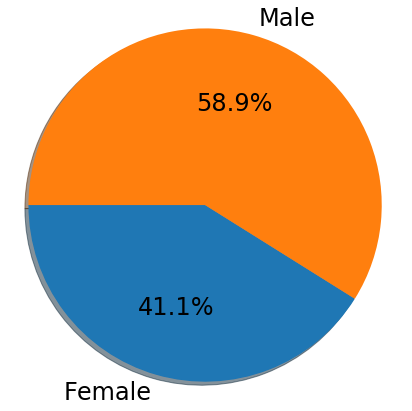

In [22]:
labels = ['Female' if i==0 else 'Male' for i in genderCounter.keys()]
value = [i for i in genderCounter.values()]

patches,texts,autotexts=plt.pie(value, labels=labels, autopct='%1.1f%%',shadow=True, startangle=180)

for i in range(len(labels)):
    texts[i].set_fontsize(24)
    autotexts[i].set_fontsize(24)
plt.axis('equal') 
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.show()

In [23]:
print(names[-5:],genders[-5:])

['hiranyadha', 'varesikh', 'jonty', 'ameerhassan', 'saumyi'] [0, 1, 1, 1, 0]


In [152]:
nGram = 2
namesWithnGram = [ ' '.join([name[idx:idx+nGram] for idx in range(len(name)-nGram+1)]) for name in names ]

In [25]:
from sklearn.model_selection import train_test_split

In [161]:
train_X,test_X,train_Y,test_Y=train_test_split(namesWithnGram,genders,test_size=0.2)

In [162]:
Counter(train_Y)

Counter({0: 18448, 1: 26416})

In [73]:
from keras.preprocessing.text import Tokenizer

In [163]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(train_X)

In [164]:
word_to_index=tokenizer.word_index
index_to_word={ index:word for word,index in word_to_index.items()}
vocab_size=len(word_to_index)
print(vocab_size)

598


In [165]:
train_sequence_text=tokenizer.texts_to_sequences(train_X)
test_sequence_text=tokenizer.texts_to_sequences(test_X)

In [39]:
from seaborn import distplot

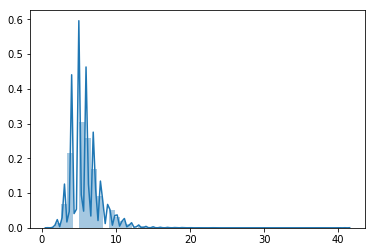

In [166]:
nameLength = [len(token) for token in train_sequence_text]
distplot(nameLength,kde=True)

In [31]:
from keras.preprocessing.sequence import pad_sequences

/home/aninda/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [167]:
trainX_pad = pad_sequences(train_sequence_text, maxlen=5, dtype='int32', padding='pre', truncating='pre', value=0)
testX_pad = pad_sequences(test_sequence_text, maxlen=5, dtype='int32', padding='pre', truncating='pre', value=0)

In [54]:
from imblearn.over_sampling import SMOTE

In [168]:
sm=SMOTE(ratio='minority',random_state=1,k_neighbors=7,m_neighbors=10)
train_x,train_y = sm.fit_resample(trainX_pad,train_Y)

In [169]:
Counter(train_y)

Counter({0: 26416, 1: 26416})

In [129]:
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense, Activation,Flatten
from keras.callbacks import ModelCheckpoint
from  keras.utils import to_categorical,plot_model
from keras.models import load_model

In [172]:
model=Sequential()
model.add(Embedding(vocab_size+1, 8,input_length = train_x.shape[1], dropout = 0.5))
# model.add(LSTM(16,activation='relu',return_sequences=True,dropout_U = 0.2))
model.add(LSTM(8,activation='relu',return_sequences=True,dropout_U = 0.2))
model.add(Flatten())
model.add(Dense(4,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adadelta',metrics = ['accuracy'])
print(model.summary())

/home/aninda/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
/home/aninda/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(8, recurrent_dropout=0.2, return_sequences=True, activation="relu")`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 5, 8)              4792      
_________________________________________________________________
lstm_30 (LSTM)               (None, 5, 8)              544       
_________________________________________________________________
flatten_14 (Flatten)         (None, 40)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 164       
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 10        
Total params: 5,510
Trainable params: 5,510
Non-trainable params: 0
_________________________________________________________________
None


In [173]:
checkpointer = ModelCheckpoint(filepath='weights_name.hdf5', verbose=1, save_best_only=True)
model.fit(train_x,to_categorical(train_y),batch_size=100,epochs=15,validation_split=0.10,callbacks=[checkpointer])

Train on 47548 samples, validate on 5284 samples
Epoch 1/15
47548/47548 [==============================] - 5s 110us/step - loss: 0.6822 - acc: 0.5660 - val_loss: 0.7303 - val_acc: 0.4217

Epoch 00001: val_loss improved from inf to 0.73031, saving model to weights_name.hdf5
Epoch 2/15
47548/47548 [==============================] - 3s 70us/step - loss: 0.5593 - acc: 0.7212 - val_loss: 0.7236 - val_acc: 0.6215

Epoch 00002: val_loss improved from 0.73031 to 0.72359, saving model to weights_name.hdf5
Epoch 3/15
47548/47548 [==============================] - 3s 71us/step - loss: 0.4948 - acc: 0.7771 - val_loss: 0.6412 - val_acc: 0.6603

Epoch 00003: val_loss improved from 0.72359 to 0.64115, saving model to weights_name.hdf5
Epoch 4/15
47548/47548 [==============================] - 3s 71us/step - loss: 0.4855 - acc: 0.7824 - val_loss: 0.6396 - val_acc: 0.6709

Epoch 00004: val_loss improved from 0.64115 to 0.63963, saving model to weights_name.hdf5
Epoch 5/15
47548/47548 [==================

In [174]:
model=load_model('weights_name.hdf5')

In [175]:
model.evaluate(testX_pad,to_categorical(test_Y),batch_size=100)

11216/11216 [==============================] - 1s 105us/step


[0.4692988016359646, 0.7920827368824356]

In [176]:
predicted = model.predict(testX_pad)
predicted = np.argmax(predicted, axis=1)

In [184]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import itertools

In [180]:
def plot_confusion_matrix(cm, classes,title,cmap=plt.cm.Set2):
    a=plt.imshow(cm, interpolation='nearest')
    plt.title(title, fontsize=30)
    plt.colorbar(fraction=.045)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt ='.2f'
    thresh = 50

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        tmp=cm[i, j]*100/sum(cm[i])
        plt.text(j, i,format(tmp,fmt), horizontalalignment="center", 
                 color="white" if tmp<thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

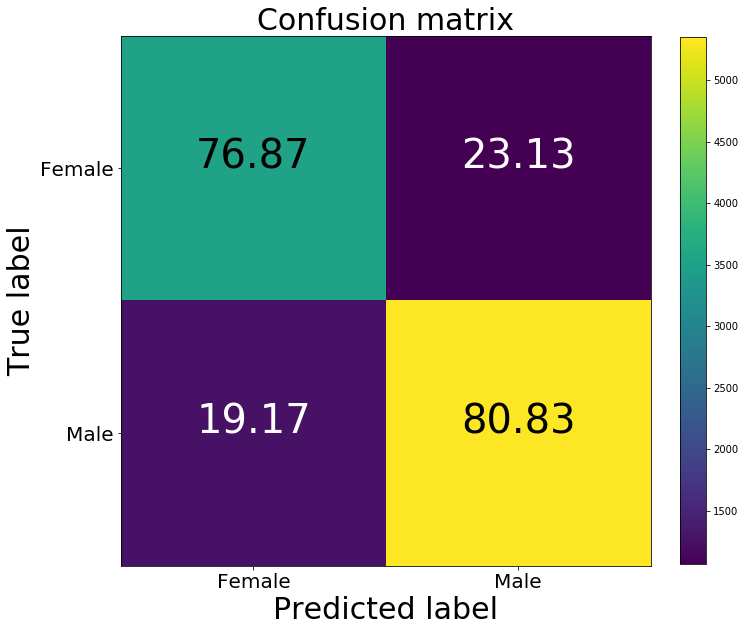

In [183]:
cm=confusion_matrix(test_Y,predicted)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Female','Male'],title='Confusion matrix')
plt.show()

In [185]:
print(classification_report(test_Y,predicted))
print('Accuracy: %.2f%%'%(accuracy_score(test_Y,predicted)*100))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75      4600
           1       0.83      0.81      0.82      6616

    accuracy                           0.79     11216
   macro avg       0.79      0.79      0.79     11216
weighted avg       0.79      0.79      0.79     11216

Accuracy: 79.21%


In [198]:
def predictName(name):
    gender=['Female','Male']
    n = 2
    names = [(re.sub(r'[^a-zA-Z]', '', row)).lower() for row in name.split()]
    tokenizedCharacter = [ ' '.join([name[idx:idx+n] for idx in range(len(name)-n+1)]) for name in names ]
    
#     finalData = [ [featuresDict_featureToIdx[feature] if feature in featuresDict_featureToIdx else 0 for feature in features] 
#               for features in tokenizedCharacter ]
    
    finalData=tokenizer.texts_to_sequences(tokenizedCharacter)
    

    
    featureVector = pad_sequences(finalData, maxlen=5, dtype='int32', padding='pre', truncating='pre', value=0)

    pred=model.predict(featureVector)

    
    result = [np.argmax(i) for i in pred]
    result = max(result,key=result.count)
    

    print("name:",name,gender[result])

In [211]:
predictName('toma')

name: toma Female
